In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

sys.path.append(os.path.expanduser("~/clef/plantclef-2025/"))

In [4]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/02 18:12:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/02 18:12:25 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/03/02 18:12:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
from pathlib import Path

home = Path.home()
knn_path = home / "shared/plantclef/data/knn"
dataset = "test_2024"
k = 50
knn_df = spark.read.parquet(str(knn_path / dataset / f"k={k}"))

In [6]:
knn_df.printSchema()
knn_df.show(5)

root
 |-- image_name: string (nullable = true)
 |-- tile: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- distances: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- nn_ids: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- grid: string (nullable = true)



+--------------------+----+--------------------+--------------------+--------------------+----+
|          image_name|tile|       cls_embedding|           distances|              nn_ids|grid|
+--------------------+----+--------------------+--------------------+--------------------+----+
|CBN-Pla-A1-201507...|  21|[0.21448913, 1.83...|[0.9790672, 1.075...|[1030958, 1232584...| 6x6|
|CBN-PdlC-D6-20190...|  24|[-0.19922814, 0.8...|[0.9749708, 1.007...|[1232584, 1030958...| 6x6|
|CBN-PdlC-C2-20140...|   8|[1.8081415, 1.974...|[1.0173109, 1.030...|[50293, 453007, 3...| 6x6|
|CBN-Pla-E3-202006...|  12|[-0.53749895, 0.4...|[1.1672064, 1.258...|[345384, 1397442,...| 6x6|
|CBN-Pla-A6-201407...|  23|[-0.61038494, 1.9...|[1.0214908, 1.056...|[490372, 445691, ...| 6x6|
+--------------------+----+--------------------+--------------------+--------------------+----+
only showing top 5 rows



In [7]:
id_map_path = home / "shared/plantclef/data/faiss/train/train_id_map"
id_df = spark.read.parquet(str(id_map_path))
id_df.printSchema()
id_df.show(5)

root
 |-- id: integer (nullable = true)
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)

+---+--------------------+----------+
| id|          image_name|species_id|
+---+--------------------+----------+
|  0|3a2c58a78ee93b471...|   1363472|
|  1|0a0bf86d70307e8db...|   1361957|
|  2|7990901729be71186...|   1363472|
|  3|80257a4818f5955f9...|   1392612|
|  4|e13e476d0dc36ed7b...|   1360562|
+---+--------------------+----------+
only showing top 5 rows



In [8]:
train_data_folder = home / "shared/plantclef/data/parquet/train"
train_data_df = spark.read.parquet(str(train_data_folder))
train_data_df.printSchema()
train_data_df.show(5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------+--------------------+
|          image_name|                path|                data|organ|species_id|    obs_id|             license|partner|          author|altitude|         latitude|         longitude|gbif_species_id|             species|        genus|    family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------

In [9]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import broadcast, col

In [10]:
image_name = "CBN-Pyr-03-20230706.jpg"
grid_size = 4
top_k = 5

tiles_pd = (
    knn_df.filter(
        (knn_df.image_name == image_name) & (knn_df.grid == f"{grid_size}x{grid_size}")
    )
    .drop("image_name", "cls_embedding", "grid")
    .toPandas()
    .sort_values(by="tile")
)
tiles_pd

tile                                          distances  \
15     0  [0.9219351, 0.95087254, 0.9674678, 0.97557044,...   
10     1  [0.9451438, 1.0129848, 1.0277965, 1.049544, 1....   
7      2  [1.120759, 1.1460371, 1.1541631, 1.1741493, 1....   
2      3  [0.7920208, 0.8471155, 0.8711324, 0.8912914, 0...   
8      4  [0.68914986, 0.86542463, 0.87394905, 0.8741140...   
5      5  [0.7992537, 0.93938327, 0.9540684, 0.9983156, ...   
13     6  [0.88515043, 0.9709194, 1.0043658, 1.0096809, ...   
11     7  [0.9594333, 1.0635457, 1.0720801, 1.0741619, 1...   
1      8  [0.90439296, 1.0220343, 1.0561008, 1.0906126, ...   
3      9  [0.581656, 0.7507403, 0.7645863, 0.77553785, 0...   
6     10  [0.9278755, 0.985595, 1.0113016, 1.0178363, 1....   
14    11  [0.93208265, 0.9475306, 0.9866221, 1.0302339, ...   
4     12  [0.9697249, 0.99374604, 1.0281062, 1.0367972, ...   
12    13  [0.9671371, 0.99512386, 1.000081, 1.0253934, 1...   
9     14  [0.92853105, 1.0336163, 1.03829, 1.038697, 1.0...   
0     15  [0.97073615, 0.98036516, 0.9825499, 1.0094837,...   

                                               nn_ids  
15  [1152194, 305589, 577961, 796106, 424864, 8803...  
10  [63740, 1125525, 613310, 1342370, 1362412, 184...  
7   [524544, 1226184, 437598, 455579, 517351, 8414...  
2   [1308193, 1347551, 1404989, 513555, 967370, 12...  
8   [12727, 544082, 426838, 1276853, 642773, 13532...  
5   [12727, 1276853, 1264283, 642773, 544082, 1392...  
13  [454917, 442642, 1336932, 612954, 869539, 1043...  
11  [12727, 544082, 642773, 132845, 1276853, 12803...  
1   [12727, 454917, 300055, 1264283, 671632, 12803...  
3   [12727, 1392655, 1280315, 1276853, 91440, 6427...  
6   [642773, 179140, 1280315, 1119836, 12727, 4487...  
14  [807943, 628599, 1218485, 967370, 107633, 2394...  
4   [216059, 1374069, 1070858, 1280315, 125713, 84...  
12  [12727, 1392655, 216059, 132845, 1374069, 1280...  
9   [1024396, 265608, 10306, 373474, 454917, 67700...  
0   [755336, 132845, 395577, 12727, 154209, 137406...

In [11]:
all_nn_ids = []
for nn_ids in tiles_pd["nn_ids"]:
    all_nn_ids.extend(nn_ids[:top_k])
all_nn_ids = list(set(all_nn_ids))

In [12]:
species_id_mapping_df = (
    id_df.filter(col("id").isin(all_nn_ids))
    .select("id", "species_id", "image_name")
    .cache()
)

In [13]:
species_ids_df = species_id_mapping_df.select("species_id").distinct()
species_ids = species_ids_df.rdd.flatMap(lambda x: x).collect()
image_names = (
    species_id_mapping_df.select("image_name")
    .distinct()
    .rdd.flatMap(lambda x: x)
    .collect()
)

In [14]:
filtered_train_df = (
    train_data_df.filter(train_data_df.image_name.isin(image_names))
    .select("image_name", "data", "species")
    .cache()
)

In [15]:
id_to_info_df = species_id_mapping_df.join(
    broadcast(filtered_train_df), "image_name", "inner"
).select("id", "species_id", "data", "species")
id_to_info_pd = id_to_info_df.toPandas()

In [16]:
id_to_data = dict(zip(id_to_info_pd["id"], id_to_info_pd["data"]))
id_to_species_id = dict(zip(id_to_info_pd["id"], id_to_info_pd["species_id"]))
id_to_species = dict(zip(id_to_info_pd["id"], id_to_info_pd["species"]))

In [17]:
species_id_mapping_df.unpersist()
filtered_train_df.unpersist()

DataFrame[image_name: string, data: binary, species: string]

In [18]:
from PIL import Image


def split_into_grid(image, grid_size):
    w, h = image.size
    grid_w, grid_h = w // grid_size, h // grid_size
    images = []
    for i in range(grid_size):
        for j in range(grid_size):
            left = i * grid_w
            upper = j * grid_h
            right = left + grid_w
            lower = upper + grid_h
            crop_image = image.crop((left, upper, right, lower))
            images.append(crop_image)
    return images

(1576, 1576)


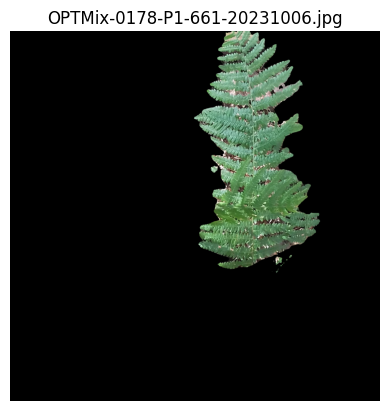

In [23]:
from plantclef.serde import deserialize_image, deserialize_mask
import cv2
import numpy as np

image_name = "CBN-Pyr-03-20230706.jpg"
# image_name = "CBN-can-E6-20230706.jpg"
image_name = "OPTMix-0178-P1-661-20231006.jpg"
# image_location = "~/shared/plantclef/data/test_2024/images/CBN-Pyr-03-20230706.jpg"
# shared/plantclef/data/test_2024/images/CBN-Pyr-03-20230706.jpg
test_mask_folder = home / "shared/plantclef/data/masking/test_2024_dev_dk"
test_mask_df = spark.read.parquet(str(test_mask_folder))

original_image_mask = (
    test_mask_df.filter(test_mask_df.image_name == image_name)
    .select("flower_mask")
    .collect()[0][0]
)
positive_mask = deserialize_mask(original_image_mask)
test_data_folder = home / "shared/plantclef/data/parquet/test_2024"
test_data_df = spark.read.parquet(str(test_data_folder))

original_image_data = (
    test_data_df.filter(test_data_df.image_name == image_name)
    .select("data")
    .collect()[0][0]
)
original_image = deserialize_image(original_image_data)


img_array = np.array(original_image.copy())
segmented = cv2.bitwise_and(img_array, img_array, mask=positive_mask)
segmented_image = Image.fromarray(segmented)
print(segmented_image.size)
# segmented_image = serialize_image(segmented)

# original_image = deserialize_image(original_image_data)
# original_image_data = "~/shared/data/test_2024/imagesCBN-Pyr-03-20230706.jpg"
# original_image = original_image_data
plt.imshow(segmented)
plt.title(image_name)
plt.axis("off")
plt.show()

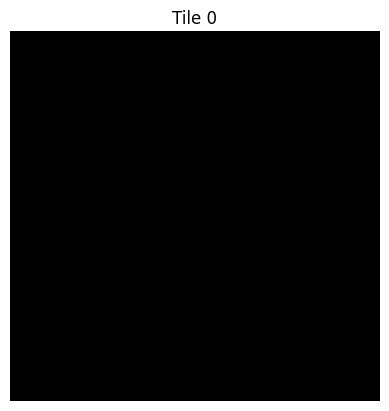

In [24]:
original_tiles = split_into_grid(segmented_image, grid_size)

plt.imshow(original_tiles[0])
plt.title("Tile 0")
plt.axis("off")
plt.show()

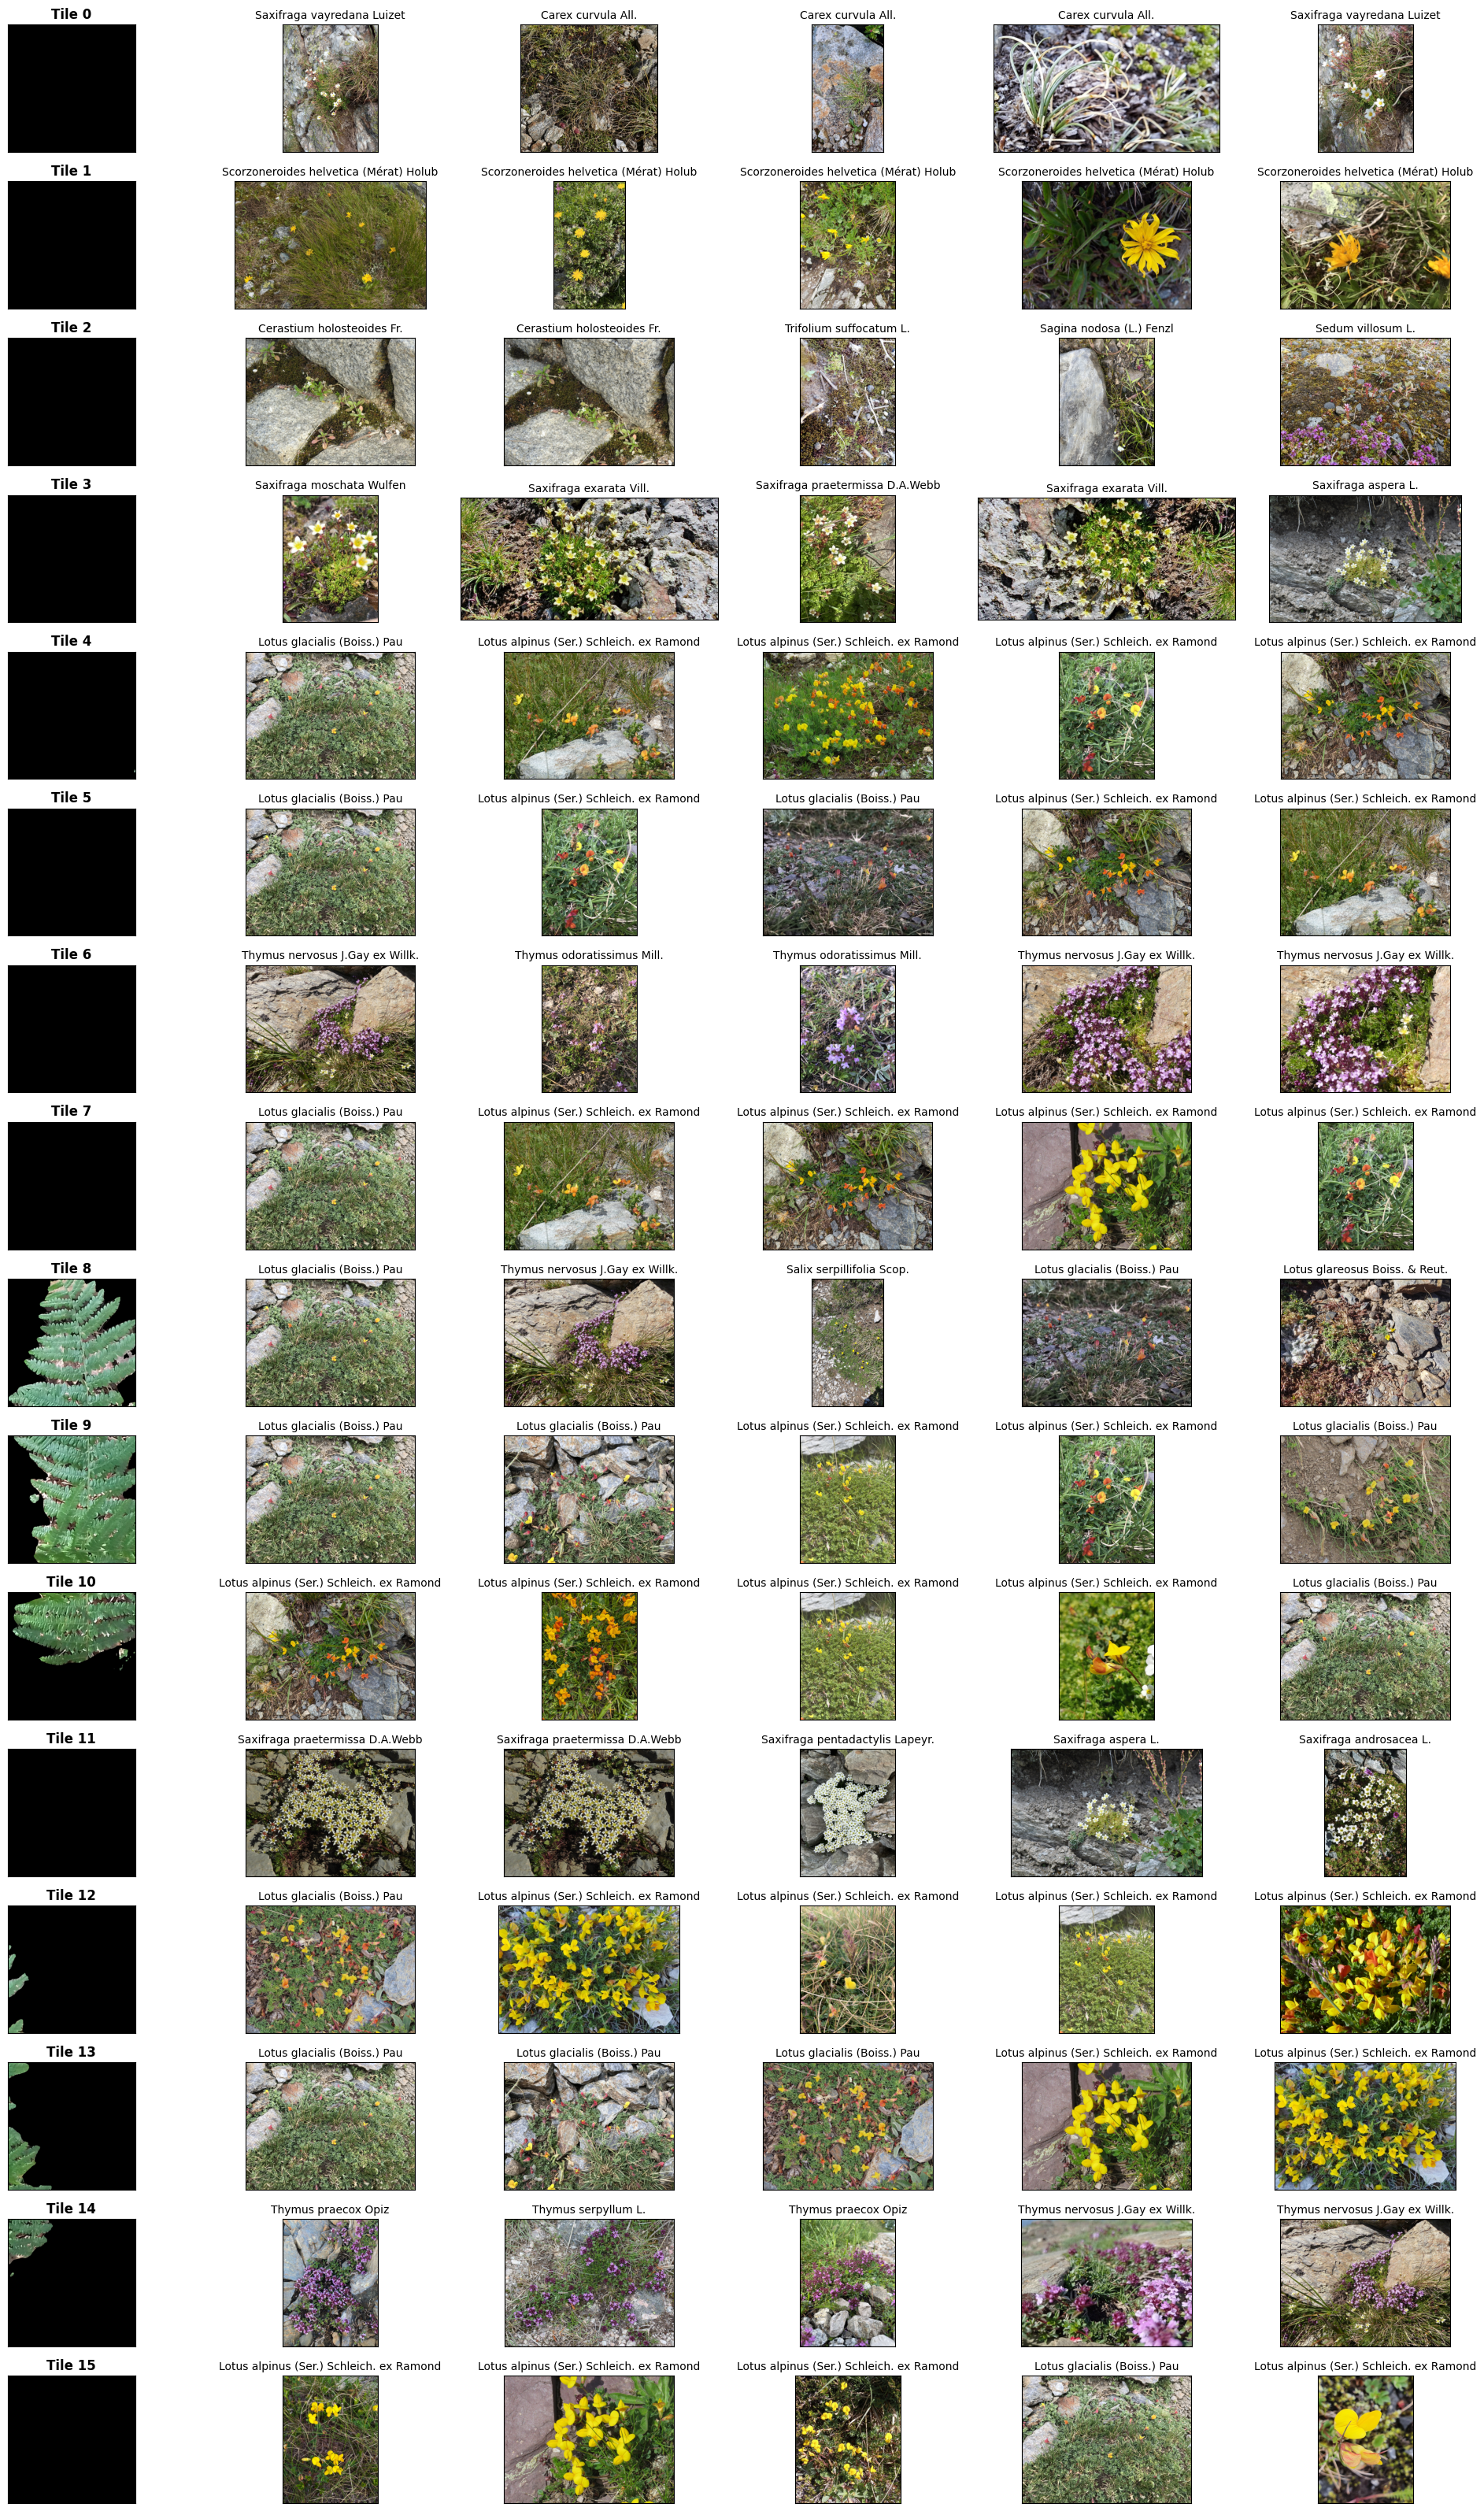

In [25]:
from textwrap import wrap

tile_nums = list(range(16))

fig, axes = plt.subplots(
    len(tile_nums), top_k + 1, figsize=((top_k + 1) * 3 + 2, len(tile_nums) * 2)
)

filtered_tiles_pd = tiles_pd[tiles_pd["tile"].isin(tile_nums)]

for i, (_, row) in enumerate(filtered_tiles_pd.iterrows()):
    tile_num = row["tile"]
    tile_nn_ids = row["nn_ids"][:top_k]

    # show original tile
    axes[i, 0].imshow(original_tiles[tile_num])
    axes[i, 0].set_title(f"Tile {tile_num}", fontweight="bold")
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    # show nearest neighbors
    for j, nn_id in enumerate(tile_nn_ids):
        image = deserialize_image(id_to_data.get(nn_id))
        species = id_to_species.get(nn_id, "Unknown")

        axes[i, j + 1].imshow(image)
        axes[i, j + 1].set_title("\n".join(wrap(species, 40)), fontsize="10")

        axes[i, j + 1].set_xticks([])
        axes[i, j + 1].set_yticks([])

plt.tight_layout()
plt.show()